1. Use the same dataset from the previous task
2. Reuse validation strategy and preprocessing without changes
3. Train xgboost model
4. Train lightgbm model
5. Train catboost model
6. Compare performance on local validation and on test set on kaggle

In [1]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [2]:
csv_train = r'https://drive.usercontent.google.com/download?id=1RIKv1X_XWYAPCsmH6UPKOue3nHu1pkGJ&export=download&authuser=0'
csv_test = r'https://drive.usercontent.google.com/download?id=1dNHk0lq04yQDpfz3_lf4PX2rZEQWrHnp&export=download&authuser=0&confirm=t&uuid=668130f8-48df-4ba3-ac54-d187c7f65b60&at=AO7h07cWJg4cofkmU9mkqR7XAEl7:1724719828412'

train_raw = pd.read_csv(csv_train)
test_raw = pd.read_csv(csv_test)

In [63]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [3]:
age_mean_train = train_raw['Age'].mean()
embarked_top_train = train_raw['Embarked'].value_counts().index[0]
fare_mean_train = train_raw['Fare'].mean()

pclass_fare = {
    1: 30,
    2: 12,
    3: 7
}

def enhance_features(data):
    data = data.copy().set_index('PassengerId')
        
    data['missing_age'] = data['Age'].isnull().astype(int)
    data['missing_fare'] = data['Fare'].isnull().astype(int)
    data['missing_embarked'] = data['Embarked'].isnull().astype(int)
    data['missing_cabin'] = data['Cabin'].isnull().astype(int)
    
    data['title'] = data['Name'].str.extract(r'[^,]*, ([^.]*)\. .*')
    data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')    
    data['cabin_letter'] = data['Cabin'].str.extract(r'([A-Za-z]*)\d*')
    
    data['Age'] = data['Age'].fillna(age_mean_train)
    data['Fare'] = data['Fare'].fillna(fare_mean_train)    
    data['Embarked'] = data['Embarked'].fillna(embarked_top_train)
    data['cabin_letter'] = data['cabin_letter'].fillna('Unknown')
    
    data['fare_per_person'] = data['Pclass'].map(pclass_fare)
    data['people_per_ticket'] = (data['Fare'] / data['fare_per_person']).round().astype(int)
    data['is_zero_price'] = (data['Fare'] == 0).astype(int)
    
    data['family_size'] = data['SibSp'] + data['Parch'] + 1
    
    return data.drop(columns=['Name', 'Ticket', 'Cabin', 'fare_per_person', 'Fare']) #, 'SibSp', 'Parch'

train_X = enhance_features(train_raw.drop(columns=['Survived']))
test_X = enhance_features(test_raw)
train_y = train_raw['Survived']

train_X

<>:20: SyntaxWarning: invalid escape sequence '\.'
<>:20: SyntaxWarning: invalid escape sequence '\.'
C:\Users\De\AppData\Local\Temp\ipykernel_17024\2935517430.py:20: SyntaxWarning: invalid escape sequence '\.'
  data['ticket_prefix'] = data['Ticket'].str.extract(r'(.*) \d*').replace('\.', '', regex=True).fillna('')


,Pclass,Sex,Age,SibSp,Parch,Embarked,missing_age,missing_fare,missing_embarked,missing_cabin,title,ticket_prefix,cabin_letter,people_per_ticket,is_zero_price,family_size
PassengerId,,,,,,,,,,,,,,,,
1,3,male,22.000000,1,0,S,0,0,0,1,Mr,A/5,Unknown,1,0,2
2,1,female,38.000000,1,0,C,0,0,0,0,Mrs,PC,C,2,0,2
3,3,female,26.000000,0,0,S,0,0,0,1,Miss,STON/O2,Unknown,1,0,1
4,1,female,35.000000,1,0,S,0,0,0,0,Mrs,,C,2,0,2
5,3,male,35.000000,0,0,S,0,0,0,1,Mr,,Unknown,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,male,27.000000,0,0,S,0,0,0,1,Rev,,Unknown,1,0,1
888,1,female,19.000000,0,0,S,0,0,0,0,Miss,,B,1,0,1
889,3,female,29.699118,1,2,S,1,0,0,1,Miss,W/C,Unknown,3,0,4


# XGB

In [89]:
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']),
    ],
    remainder='passthrough'
)

train_X_preprocessed = preprocessor.fit_transform(train_X)
test_X_preprocessed = preprocessor.transform(test_X)

feature_names = list(preprocessor.get_feature_names_out())
xgb_train = xgb.DMatrix(train_X_preprocessed, train_y, feature_names=feature_names)
xgb_test = xgb.DMatrix(test_X_preprocessed, feature_names=feature_names)

feature_names

['one_hot__Sex_female',
 'one_hot__Sex_male',
 'one_hot__Embarked_C',
 'one_hot__Embarked_Q',
 'one_hot__Embarked_S',
 'one_hot__title_Capt',
 'one_hot__title_Col',
 'one_hot__title_Don',
 'one_hot__title_Dr',
 'one_hot__title_Jonkheer',
 'one_hot__title_Lady',
 'one_hot__title_Major',
 'one_hot__title_Master',
 'one_hot__title_Miss',
 'one_hot__title_Mlle',
 'one_hot__title_Mme',
 'one_hot__title_Mr',
 'one_hot__title_Mrs',
 'one_hot__title_Ms',
 'one_hot__title_Rev',
 'one_hot__title_Sir',
 'one_hot__title_the Countess',
 'one_hot__ticket_prefix_',
 'one_hot__ticket_prefix_A/4',
 'one_hot__ticket_prefix_A/5',
 'one_hot__ticket_prefix_A/S',
 'one_hot__ticket_prefix_A4',
 'one_hot__ticket_prefix_A5',
 'one_hot__ticket_prefix_C',
 'one_hot__ticket_prefix_CA',
 'one_hot__ticket_prefix_CA/SOTON',
 'one_hot__ticket_prefix_FC',
 'one_hot__ticket_prefix_FCC',
 'one_hot__ticket_prefix_Fa',
 'one_hot__ticket_prefix_P/PP',
 'one_hot__ticket_prefix_PC',
 'one_hot__ticket_prefix_PP',
 'one_hot__t

In [90]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = make_scorer(f1_score)

parameters1 = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "nthread": -1,
}

results1 = xgb.cv(parameters1, xgb_train, folds=cv,num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)
results1[-1:]

[0]	train-error:0.18045+0.01031	test-error:0.19647+0.04171


[10]	train-error:0.10912+0.00499	test-error:0.18416+0.04350
[11]	train-error:0.10762+0.00516	test-error:0.18303+0.04432


,train-error-mean,train-error-std,test-error-mean,test-error-std
1,0.145032,0.005144,0.176255,0.028225


In [119]:
parameters2 = {
    "objective": "binary:logistic",
    "eval_metric": "error",
    "eta": 0.2,
    "nthread": -1,
    
    #"max_leaves": 30,
    "max_depth": 3,
    "subsample": 1,
    "colsample_bytree": 0.6,
    
    "reg_alpha": 0.1,
}

results2 = xgb.cv(parameters2, xgb_train, folds=cv,num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)
print(results2[-1:])

# Get F1 score to compare to the previous models' results
xgbClassifier = xgb.XGBClassifier(random_state=0, **parameters2, n_estimators= results2.shape[0])
cv_results_xgb = cross_val_score(xgbClassifier, train_X_preprocessed, train_y, cv=cv, scoring=scoring)
print(f'F1 score on cross-validation: {cv_results_xgb.mean()}')

bst1 = xgb.train(parameters2, xgb_train, num_boost_round=results2.shape[0])
bst1_train_y_predict = (bst1.predict(xgb_train) >= 0.5).astype(int)
bst1_train_score = f1_score(bst1_train_y_predict, np.array(train_y))
print(f'F1 score on all train data: {bst1_train_score}')

[0]	train-error:0.36638+0.05230	test-error:0.37035+0.04122


[10]	train-error:0.16124+0.00669	test-error:0.17845+0.01276
[20]	train-error:0.14815+0.00622	test-error:0.17060+0.02062
[30]	train-error:0.13593+0.00502	test-error:0.17738+0.03737
    train-error-mean  train-error-std  test-error-mean  test-error-std
21          0.146153         0.005092         0.163895        0.031603
F1 score on cross-validation: 0.7761184971902721
F1 score on all train data: 0.8024132730015083


In [120]:
xgbClassifier.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'error',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 22,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 0,
 'reg_alpha': 0.1,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.2,
 'nthread': -1}

In [121]:
xgb_test_results2 = test_X.copy()
xgb_test_results2['Survived'] = (bst1.predict(xgb_test) >= 0.5).astype(int)
xgb_test_results2['Survived'].to_csv('xgb_test_results.csv', index=True)

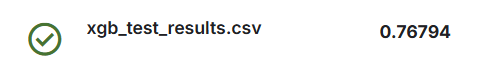

XGBClassifier performs better on cross-validation without overfitting on all train data. Kaggle test is better than Random Forest but worse than bagging.

XGBClassifier:
- F1 score on cross-validation: 0.7761184971902721
- F1 score on all train data: 0.8024132730015083

RandomForestClassifier:
- Best_params {'max_depth': 5, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 3, 'n_estimators': 100}
- F1 score on cross-validation: 0.7691404154156668
- F1 score on all train data: 0.8048780487804879

# LightGBM

We saw on xgb example that titanic dataset is small and early stopping doesn't improve time much. So let's just use grid search without early stopping

In [122]:
categorical_feature = ['Sex', 'Embarked', 'title', 'ticket_prefix', 'cabin_letter']

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = make_scorer(f1_score)

def preprocess_features(df):
    df_lgb_adjusted = df.copy()
    for col in categorical_feature:
        df_lgb_adjusted[col] = df_lgb_adjusted[col].astype('category')
        
    return df_lgb_adjusted

lgb_train = lgb.Dataset(preprocess_features(train_X), label=train_y, free_raw_data=False)
lgb_test = lgb.Dataset(preprocess_features(test_X), free_raw_data=False)

In [123]:
lgb_params1 = {
    'objective': 'binary',
    'metric': 'binary_logloss', # 'auc'
    'boosting_type': 'gbdt',
    
    # 'learning_rate': 0.1,
    #'num_leaves': 31,
    # "colsample_bytree": 0.8,
    # "subsample": 0.8,
    # "subsample_freq": 1,
    # 'verbosity': -1    
}
lgb_rounds = 1000
    
lgb.cv(lgb_params1, lgb_train, lgb_rounds, folds=cv, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(period=100)])

c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	cv_agg's valid binary_logloss: 0.419394 + 0.0562488


{'valid binary_logloss-mean': [0.6242402271531206,
  0.5916523696244018,
  0.5651617236140762,
  0.5433609407047462,
  0.5255010764243424,
  0.5093997546958545,
  0.4957701812175313,
  0.48446732861354114,
  0.4736955539160556,
  0.4648627774419526,
  0.4591776260979813,
  0.4529173001165433,
  0.4474000295703641,
  0.44221821229185937,
  0.43896423009360735,
  0.4356811165872732,
  0.43245944911375167,
  0.4302967829470673,
  0.42809448161808383,
  0.426630011783668,
  0.4257919005320461,
  0.4240717661832831,
  0.4235195945181089,
  0.422637162798273,
  0.42155605827208575,
  0.42060759351886967,
  0.42020969293883137,
  0.41939350353111615],
 'valid binary_logloss-stdv': [0.005677867215867185,
  0.010986900788293983,
  0.015582730246821695,
  0.01954438929784988,
  0.023442323760077936,
  0.025246779386797452,
  0.028255903570766475,
  0.030466202949868352,
  0.0325334103904123,
  0.03394967324436444,
  0.037038896824402985,
  0.03907359867214575,
  0.0406063123311481,
  0.042780491

In [174]:
lgb_params2 = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    
    'learning_rate': 0.1,
    
    'min_data_in_leaf': 5,
    'min_data_per_group': 20,
    'num_leaves': 9,
    
    'colsample_bytree': 0.5,
    'subsample': 0.4,
        
    'cat_smooth': 10, 
}
lgb_rounds = 1000
    
lgb_results2 = lgb.cv(lgb_params2, lgb_train, lgb_rounds, folds=cv, callbacks=[lgb.early_stopping(10), lgb.log_evaluation(period=100)])
lgb_rounds_ = len(list(lgb_results2.items())[0][1])

lgbClassifier = lgb.LGBMClassifier(random_state=3, **lgb_params2, lgb_rounds=lgb_rounds_)
lgbClassifier_results = cross_val_score(lgbClassifier, preprocess_features(train_X), train_y, cv=cv, scoring=scoring)
print(f'F1 score on cross-validation: {lgbClassifier_results.mean()}')

lgbClassifier.fit(preprocess_features(train_X), train_y)
lgb1_train_y_predict = (lgbClassifier.predict(preprocess_features(train_X)) >= 0.5).astype(int)
lgb1_train_score = f1_score(lgb1_train_y_predict, np.array(train_y))
print(f'F1 score on all train data: {lgb1_train_score}')


c:\Python\envs\ds1\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	cv_agg's valid binary_logloss: 0.401967 + 0.0544126
F1 score on cross-validation: 0.7631528068603648
F1 score on all train data: 0.8473520249221184


In [155]:
lgbm_test_results = test_X.copy()
lgbm_test_results['Survived'] = (lgbClassifier.predict(preprocess_features(test_X)) >= 0.5).astype(int)
lgbm_test_results['Survived'].to_csv('lgbm_test_results.csv', index=True)

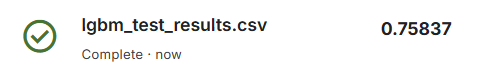

LGBMClassifier performs about the same asXGBClassifier

LGBMClassifier:
- F1 score on cross-validation: 0.7746596113051026
- F1 score on all train data: 0.8492307692307692

XGBClassifier:
- F1 score on cross-validation: 0.7761184971902721
- F1 score on all train data: 0.8024132730015083

RandomForestClassifier:
- Best_params {'max_depth': 5, 'max_features': 0.75, 'max_samples': 0.75, 'min_samples_leaf': 3, 'n_estimators': 100}
- F1 score on cross-validation: 0.7691404154156668
- F1 score on all train data: 0.8048780487804879